First, let's turn on matplotlib inline so we can see pretty visualisations inside the notebook

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pylab as pl

In [3]:
import PIL
from PIL import Image

In [4]:
import os
import base64
from StringIO import StringIO

In [5]:
from sklearn.decomposition import RandomizedPCA
from sklearn.neighbors import KNeighborsClassifier

In [6]:
def img_to_matrix(filename, verbose=False):
    newsize = (400, 400)
    img = PIL.Image.open(filename)
    if verbose==True:
        print "changing size from %s to %s" % (str(img.size), str(newsize))
    img = img.resize(newsize)
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    return img

def flatten_image(img):
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

In [7]:
img_dir = "images/"

In [8]:
images = [img_dir+ f for f in os.listdir(img_dir)]

We're using filenames as labels, if it has snow in the filename, it's a snow picture

In [9]:
labels = ["snow" if "snow" in f.split('/')[-1] else "dirt" for f in images]

In [10]:
data = []

In [11]:
for image in images:
    try:
        img = img_to_matrix(image)
        img = flatten_image(img)
        data.append(img)
    except:
        print image

We've just normalised all the images to 400x400, and then turned each image in to a long 1D array of pixels. Some small part of you is probably screaming "What are you doing? That is the worst idea ever!" Hang in there, it'll make sense in a  minute

In [12]:
data = np.array(data)

Let's have a look at what we're dealing with

In [13]:
data

array([[  0,   0,   0, ..., 170, 163,  95],
       [255, 255, 255, ..., 103, 102, 107],
       [210, 230, 239, ..., 122, 116,  56],
       ..., 
       [  0,   0,  41, ..., 106, 102,  93],
       [  3,   3,   3, ..., 155, 149, 149],
       [ 53,  56,  47, ..., 185, 159, 126]])

Right now we've got a huge pile of images. We need to keep some back from our model, or else we won't know if the model is working or not. Let's split our dataset in to a training and a testing set'

In [14]:
is_train = np.random.uniform(0, 1, len(data)) <= 0.8

In [15]:
y = np.where(np.array(labels)=="snow", 1, 0)

In [16]:
train_x, train_y = data[is_train], y[is_train]

In [17]:
test_x, test_y = data[is_train==False], y[is_train==False]

Here i tried a PCA (https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the dimensionality of the data. Analysing 160,000 features (which is how many pixels we have per image) is usually not a great idea because there's a lot of totally non-predictive noise in there.

However, as you'll see, we were actually better off using the tree pruning power of the SVM in the end to make those decisions

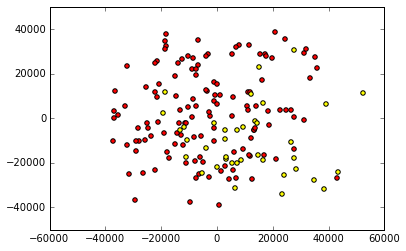

In [34]:
pca = RandomizedPCA(n_components=80)
X = pca.fit_transform(data)
df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "label":np.where(y==1, "Snow", "Dirt")})
colors = ["red", "yellow"]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    pl.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)

Ideally we'd like to see all those red dots clumped close to the top left corner, and all the yellow ones clumped close to the bottom right. At the moment they are a bit all over the shop. If we had more time, we'd probably look at what pre-processing might improve the quality of the dataset (Some ideas: Using OpenCV to normalise all the brightnesses, checking our 'marginal' classifications to throw out snow-y images that are classified as dirt, cropping off the banners (which are pure noise as far as prediction is concerned). Probably some others I haven't thought of')

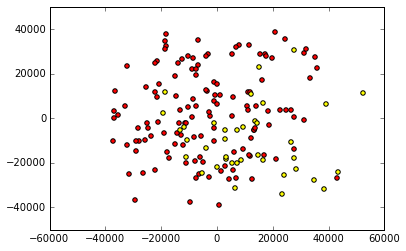

In [36]:
pca = RandomizedPCA(n_components=5)
X = pca.fit_transform(data)
df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "label":np.where(y==1, "Snow", "Dirt")})
colors = ["red", "yellow"]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    pl.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)

### Pro tip: Try messing with the n_components= parameter. It might surprise you how much predictive power you can get from *fewer* features. Try 5, then 500 (may take a while)

Ok, let's try something simple: KNN is a distance-based algo. It takes some features of one thing and tries to find the one most like it. It works great for some things, terrible for others

In [38]:
knn = KNeighborsClassifier()
knn.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [67]:
pd.crosstab(test_y, knn.predict(test_x), rownames=["Tagged"], colnames=["My guess"])

My guess   0  1
Tagged         
0         33  4
1         12  4

Not too bad, we're getting 69% of our testing set correct.

Now according to some guys in India, their best effort at detecting snow was with a Perceptron, which is a type of neural net. SKLearn doesn't have a multi-layer perceptron, but let's try the linear one anyway. I have no idea what parameters I even *should* tune yet, so let's go with the defaults

In [42]:
from sklearn import linear_model

In [43]:
classifier = linear_model.Perceptron()

In [44]:
classifier.fit(train_x, train_y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [45]:
pd.crosstab(test_y, classifier.predict(test_x), rownames=["Tagged"], colnames=["My guess"])

My guess   0  1
Tagged         
0         30  1
1          8  3

Much better. 78%

Let's take a look at the Data scientist's best friend, the Support Vector Machine. These things tend to produce great results, even though it's not always clear how they do it. Decision trees are much easier to visualise (We'll do one below), but SVM's make mincemeat of dirty data.

(They're also fairly computationally intensive, so this one may take a while to run)

In [47]:
from sklearn import svm

In [48]:
newclassifier = svm.LinearSVC()

In [49]:
newclassifier.fit(train_x,train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [51]:
pd.crosstab(test_y, newclassifier.predict(test_x), rownames=["Tagged"], colnames=["My guess"])

My guess   0  1
Tagged         
0         30  1
1          6  5

In [ ]:
35 / 42. That's an 83% classification rate. Let's bottle that before we start messing with anything else.

Training models (especially on big datasets) can be pretty slow, so once you have one you like it's a good idea to write it to disk

In [52]:
import pickle

In [54]:
model = pickle.dumps(newclassifier)

In [55]:
from sklearn.externals import joblib

In [56]:
joblib.dump(newclassifier,'testmodel.pkl')

['testmodel.pkl',
 'testmodel.pkl_01.npy',
 'testmodel.pkl_02.npy',
 'testmodel.pkl_03.npy']

In [62]:
from sklearn.ensemble import RandomForestClassifier

ImportError: cannot import name tree

In [59]:
forestclf = RandomForestClassifier()

In [60]:
forestclf.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
pd.crosstab(test_y, forestclf.predict(test_x), rownames=["Tagged"], colnames=["My guess"])

My guess   0  1
Tagged         
0         30  1
1          7  4

80.1% - Not as good as our SVM.

Finally, let's do something we can visualise the results of, a decision tree

In [18]:
from sklearn import tree

In [19]:
treeclf=tree.DecisionTreeClassifier()

In [20]:
treeclf.fit(train_x,train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [21]:
pd.crosstab(test_y, treeclf.predict(test_x), rownames=["Tagged"], colnames=["My guess"])

My guess   0  1
Tagged         
0         23  5
1          2  4

In [22]:
from sklearn.externals.six import StringIO

In [29]:
import pydot

In [24]:
dot_data = StringIO()

In [25]:
tree.export_graphviz(treeclf, out_file=dot_data)

In [26]:
graph = pydot.graph_from_dot_data(dot_data.getvalue())

In [30]:
graph.write_pdf("snowtree.pdf")

error: (2, 'RegOpenKeyEx', 'The system cannot find the file specified.')

In [28]:
graph.write_png('test.png')

error: (2, 'RegOpenKeyEx', 'The system cannot find the file specified.')

In [31]:
graph

In [ ]:
graph.display